# Rescheduling mit Tardiness (Summe)
> Planunghorizont Tag 0: 2 Tage
> Rescheduling des Tages 1

In [5]:
max_time = 60*30 # 1/2h

In [6]:
import time

In [7]:
from ortools.sat.python import cp_model
import pandas as pd
import numpy as np
import math

pd.set_option('display.max_rows', 20)

In [8]:
import utils.presenter as show
import utils.checker as check

import utils.schedule_interarrival as sit
import utils.scheduling_solver as ssv

from ProductionDaySimulation import ProductionDaySimulation

In [9]:
import utils.rolling_planning.init_jobs_times as rp_init
import utils.schedule_deadline as deadline_gen

In [10]:
df_instance = pd.read_csv("data/00_instance.csv")
df_instance

,Job,Operation,Machine,Processing Time
0,job 0,0,M0,29
1,job 0,1,M1,78
2,job 0,2,M2,9
3,job 0,3,M3,36
4,job 0,4,M4,49
...,...,...,...,...
95,job 9,5,M9,76
96,job 9,6,M5,47
97,job 9,7,M3,52
98,job 9,8,M4,90


In [11]:
df_jssp, df_arrivals = rp_init.init_jobs_with_arrivals(df_instance, 3,  u_b_mmax = 0.95)
df_jssp

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
565,Job_056,5,M9,76
566,Job_056,6,M5,47
567,Job_056,7,M3,52
568,Job_056,8,M4,90


In [12]:
# Arrival-Werte durchmischen (aber nicht verändern)
#df_arrivals['Arrival'] = df_arrivals['Arrival'].sample(frac=1.0, random_state=42).reset_index(drop=True)
#df_arrivals

In [13]:
df_times = deadline_gen.get_times_df(df_jssp, df_arrivals, ssv.schedule_fcfs_with_arrivals, target_service=1.0)
df_times["Arrival"] = np.floor(df_times["Arrival"]).astype(int)
df_times["Deadline"] = np.ceil(df_times["Deadline"]).astype(int)
df_times

,Job,Arrival,Deadline
0,Job_000,0,1151
1,Job_001,83,1570
2,Job_002,144,1800
3,Job_003,197,2106
4,Job_004,233,1379
...,...,...,...
52,Job_052,4008,5917
53,Job_053,4014,5160
54,Job_054,4015,5671
55,Job_055,4134,5286


## I) Complete Scheduling

In [14]:
starting_time = time.time()

# Scheduling
df_plan = ssv.solve_cp_jssp_lateness_by_tardiness_and_earliness(df_jssp, df_times,w_t = 5,
                                                                msg=False, timeLimit=max_time, gapRel= 0.00)
df_plan

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan


Solver-Status         : OPTIMAL
Objective Value       : 126.00
Best Objective Bound  : 126.00
Laufzeit              : 0.67 Sekunden

Scheduling-Dauer: 0 Minuten und 0.71 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_000,0,0,1151,M0,0,29,29,-1122,0,1122
1,Job_000,1,0,1151,M1,29,78,107,-1044,0,1044
2,Job_001,0,83,1570,M0,83,43,126,-1444,0,1444
3,Job_000,2,0,1151,M2,107,9,116,-1035,0,1035
4,Job_000,3,0,1151,M3,116,36,152,-999,0,999
...,...,...,...,...,...,...,...,...,...,...,...
565,Job_051,9,4003,5449,M7,5424,25,5449,0,0,0
566,Job_049,9,3774,5515,M8,5441,74,5515,0,0,0
567,Job_054,9,4015,5671,M4,5638,33,5671,0,0,0
568,Job_056,9,4234,5808,M7,5763,45,5808,0,0,0


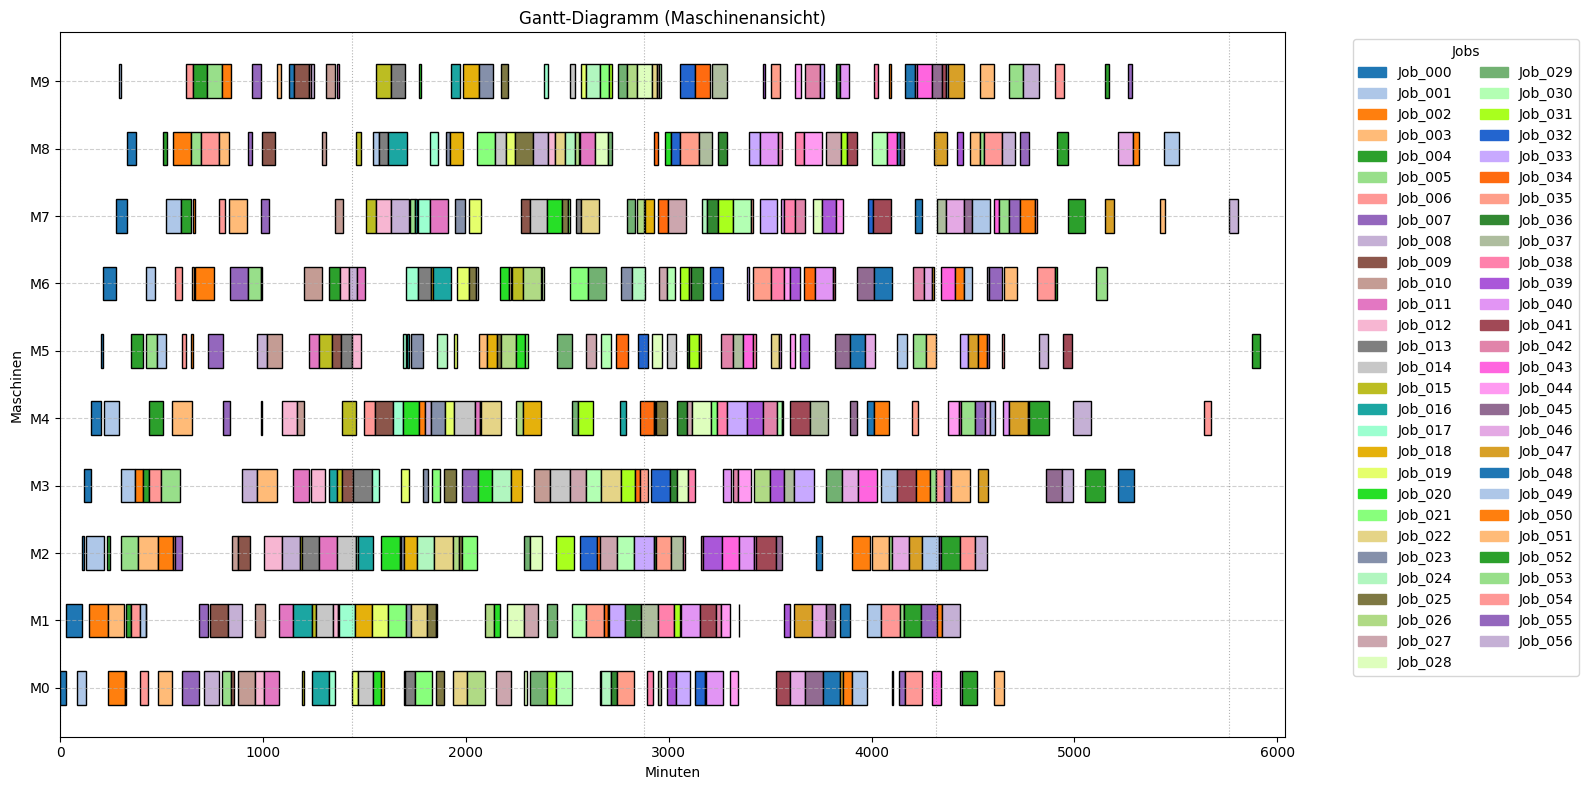

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job


True

In [15]:
show.plot_gantt_machines(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

## II) Erster Tag (Tag 0)

### a) Simulation

In [16]:
day_length = 1440

In [17]:
day_numb = 0

day_start = day_length*day_numb 
day_end = day_start + day_length

In [18]:
simulation = ProductionDaySimulation(df_plan, vc=0.35)
df_execution, df_undone = simulation.run(start_time = day_start, end_time=day_end)

[00:00:00] Job_000 started on M0
[00:13:11] Job_000 finished on M0 (after 13 minutes 12 seconds)
[00:29:00] Job_000 started on M1
[01:23:00] Job_001 started on M0
[01:58:19] Job_001 finished on M0 (after 35 minutes 20 seconds)
[02:06:00] Job_001 started on M2
[02:16:13] Job_000 finished on M1 (after 107 minutes 13 seconds)
[02:24:00] Job_002 started on M1
[04:01:14] Job_002 finished on M1 (after 97 minutes 14 seconds)
[04:01:14] Job_003 started on M1
[04:01:14] Job_002 started on M0
[04:19:52] Job_001 finished on M2 (after 133 minutes 52 seconds)
[04:19:52] Job_000 started on M2
[04:19:52] Job_001 started on M4
[04:27:41] Job_000 finished on M2 (after 07 minutes 49 seconds)
[04:27:41] Job_004 started on M2
[04:27:41] Job_000 started on M3
[04:46:51] Job_004 finished on M2 (after 19 minutes 10 seconds)
[04:55:25] Job_000 finished on M3 (after 27 minutes 44 seconds)
[05:02:00] Job_005 started on M2
[05:21:54] Job_001 finished on M4 (after 62 minutes 02 seconds)
[05:21:54] Job_000 started

In [19]:
df_undone

,Job,Operation,Arrival,Machine,Planned Start,Processing Time
0,Job_011,5,894,M9,1363,11
1,Job_014,1,1128,M2,1363,95
2,Job_017,1,1254,M1,1374,78
3,Job_012,6,950,M6,1379,46
4,Job_009,7,740,M3,1391,52
...,...,...,...,...,...,...
442,Job_051,9,4003,M7,5424,25
443,Job_049,9,3774,M8,5441,74
444,Job_054,9,4015,M4,5638,33
445,Job_056,9,4234,M7,5763,45


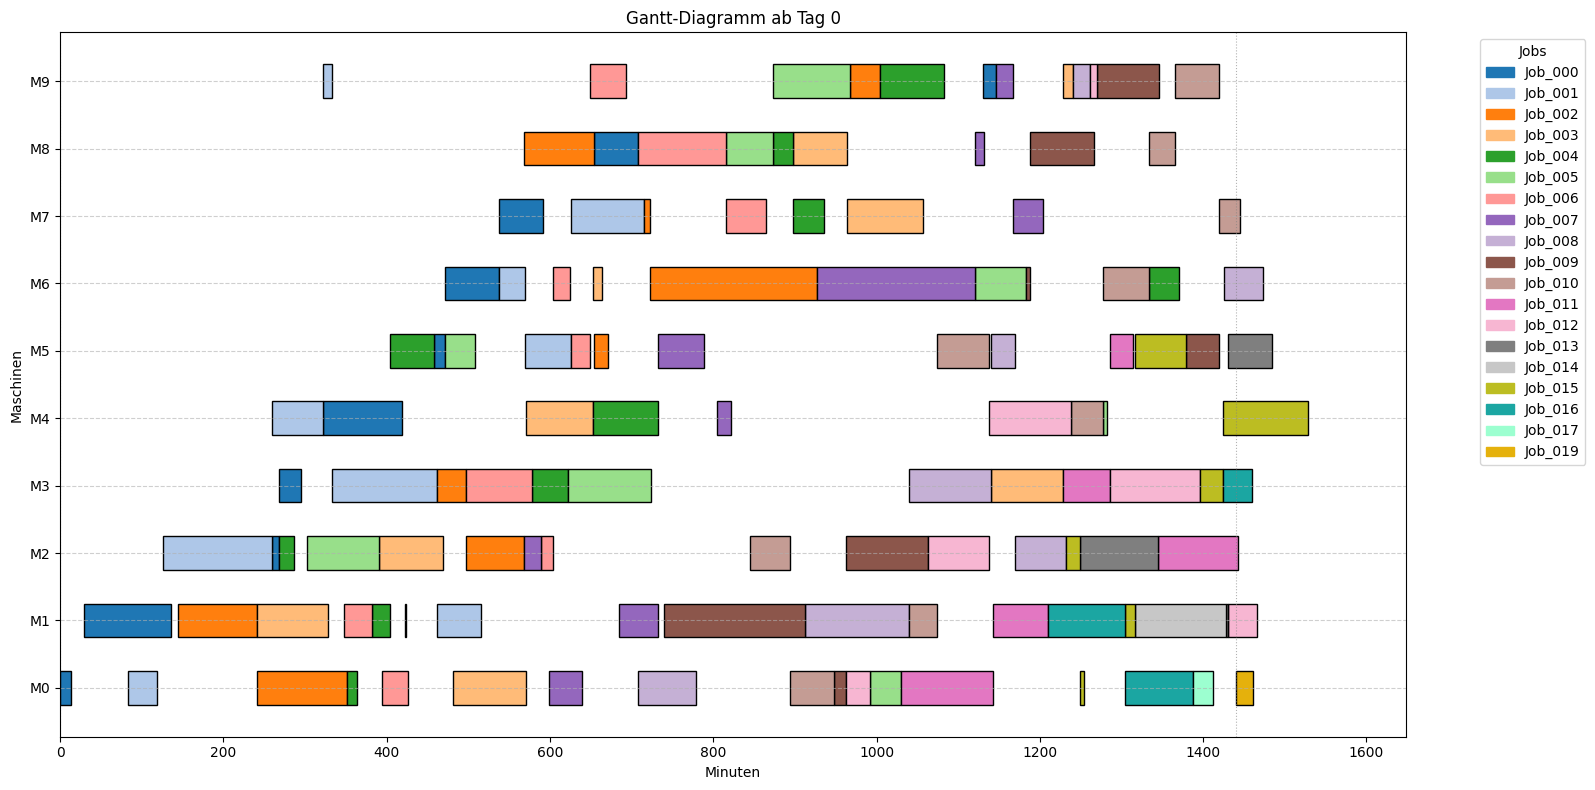

In [20]:
if not df_execution.empty:
    show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm ab Tag {day_numb}", duration_column="Simulated Processing Time")
else:
    print(f"Nothing executed on day {day_numb}")

### b) Verbleibene Jobs (Rest)

In [21]:
df_rest = df_plan.merge(df_execution[["Job", "Machine"]], on=["Job", "Machine"], how="left", indicator=True)
df_rest = df_rest[df_rest["_merge"] == "left_only"].drop(columns=["_merge"])
df_rest = df_rest.sort_values(by=["Arrival", "Start"]).reset_index(drop=True)
df_rest

,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_001,9,83,1570,M8,1540,30,1570,0,0,0
1,Job_002,9,144,1800,M4,1767,33,1800,0,0,0
2,Job_003,9,197,2106,M5,2063,43,2106,0,0,0
3,Job_005,9,302,1748,M7,1723,25,1748,0,0,0
4,Job_006,9,340,1553,M4,1498,55,1553,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
442,Job_056,5,4234,5808,M9,4749,76,4825,-983,0,983
443,Job_056,6,4234,5808,M5,4825,47,4872,-936,0,936
444,Job_056,7,4234,5808,M3,4939,52,4991,-817,0,817
445,Job_056,8,4234,5808,M4,4991,90,5081,-727,0,727


In [22]:
allowed = df_rest["Job"].unique() 
df_time_rest = df_times[df_times["Job"].isin(allowed)].copy()
df_time_rest

,Job,Arrival,Deadline
1,Job_001,83,1570
2,Job_002,144,1800
3,Job_003,197,2106
5,Job_005,302,1748
6,Job_006,340,1553
...,...,...,...
52,Job_052,4008,5917
53,Job_053,4014,5160
54,Job_054,4015,5671
55,Job_055,4134,5286


## III) Rescheduling
> vereinfacht, ohne neu Aufträge (nur der Rest)

In [23]:
# Reduktion der bereits ausgeführten Operationen auf die relevanten für die nächsten Tage
df_execution_important = df_execution[df_execution["End"] >= 1440]
df_execution_important

,Job,Operation,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
80,Job_008,6,708,M6,1425.00,48.36,765.36,1473.36
96,Job_010,8,845,M7,1419.17,26.22,600.39,1445.39
101,Job_011,4,894,M2,1344.61,98.17,548.78,1442.78
107,Job_012,5,950,M1,1431.02,35.38,516.40,1466.40
110,Job_013,2,1123,M5,1431.02,52.97,360.99,1483.99
117,Job_015,5,1134,M4,1424.71,104.02,394.73,1528.73
120,Job_016,2,1135,M3,1424.71,35.18,324.89,1459.89
122,Job_019,0,1440,M0,1440.00,20.69,20.69,1460.69


In [24]:
def solve_cp_jssp_lateness_by_tardiness_and_earliness_with_fixed_ops(
    df_jssp: pd.DataFrame,
    df_arrivals_deadlines: pd.DataFrame,
    df_executed: pd.DataFrame,
    w_t: int = 5,
    w_e: int = 1,
    reschedule_start: float = 1440.0,
    sort_ascending: bool = False,
    msg: bool = False,
    timeLimit: int = 3600,
    gapRel: float = 0.0
) -> pd.DataFrame:
    model = cp_model.CpModel()

    # Sicherstellen, dass die Gewichte ganzzahlig sind (CP-SAT Voraussetzung)
    w_t = int(w_t)
    w_e = int(w_e)

    # === Vorbereitung: Jobliste, Ankünfte und Deadlines ===
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # === Operationen je Job gruppieren ===
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = int(row["Operation"])
            m = str(row["Machine"])
            d = int(round(row["Processing Time"]))
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    # === Grober Planungshorizont (für obere Schranken) ===
    horizon = int(df_jssp["Processing Time"].sum() + max(deadline.values()))

    # === Fest eingeplante Operationen, die beim Rescheduling nicht verändert werden dürfen ===
    df_executed_fixed = df_executed[df_executed["End"] >= reschedule_start]
    fixed_ops = {
        m: list(grp[["Start", "End"]].itertuples(index=False, name=None))
        for m, grp in df_executed_fixed.groupby("Machine")
    }

    # === Variablen definieren ===
    starts, ends, intervals = {}, {}, {}
    weighted_terms = []

    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            suffix = f"{j}_{o}"
            start = model.NewIntVar(0, horizon, f"start_{suffix}")
            end = model.NewIntVar(0, horizon, f"end_{suffix}")
            interval = model.NewIntervalVar(start, d, end, f"interval_{suffix}")
            starts[(j, o)] = start
            ends[(j, o)] = end
            intervals[(j, o)] = (interval, m)

    # === Zielfunktion: gewichtete Tardiness + Earliness ===
    for j, job in enumerate(jobs):
        last_op_index = len(all_ops[j]) - 1
        job_end = ends[(j, last_op_index)]

        # Lateness = tatsächliches Ende – Deadline
        lateness = model.NewIntVar(-horizon, horizon, f"lateness_{j}")
        model.Add(lateness == job_end - deadline[job])

        # Tardiness = max(0, Lateness)
        tardiness = model.NewIntVar(0, horizon, f"tardiness_{j}")
        model.AddMaxEquality(tardiness, [lateness, 0])
        term_tardiness = model.NewIntVar(0, horizon * w_t, f"term_tardiness_{j}")
        model.Add(term_tardiness == w_t * tardiness)
        weighted_terms.append(term_tardiness)

        # Earliness = max(0, -Lateness)
        earliness = model.NewIntVar(0, horizon, f"earliness_{j}")
        model.AddMaxEquality(earliness, [-lateness, 0])
        term_earliness = model.NewIntVar(0, horizon * w_e, f"term_earliness_{j}")
        model.Add(term_earliness == w_e * earliness)
        weighted_terms.append(term_earliness)

        # Ankunftsbedingung + Rescheduling-Startzeit
        model.Add(starts[(j, 0)] >= arrival[job])
        model.Add(starts[(j, 0)] >= int(reschedule_start))

        # Falls vorherige Operationen des Jobs bereits geplant wurden
        if job in df_executed["Job"].values:
            last_fixed_end = df_executed[df_executed["Job"] == job]["End"].max()
            model.Add(starts[(j, 0)] >= int(math.ceil(last_fixed_end)))

        # Technologische Reihenfolge einhalten
        for o in range(1, len(all_ops[j])):
            model.Add(starts[(j, o)] >= ends[(j, o - 1)])

    # === Maschinenrestriktionen: Keine Überlappungen, auch mit fixen Intervallen ===
    for m in machines:
        machine_intervals = [interval for (j, o), (interval, mach) in intervals.items() if mach == m]

        for fixed_start, fixed_end in fixed_ops.get(m, []):
            start = math.floor(fixed_start)
            end = math.ceil(fixed_end)
            duration = end - start
            fixed_interval = model.NewIntervalVar(start, duration, end, f"fixed_{m}_{end}")
            machine_intervals.append(fixed_interval)

        model.AddNoOverlap(machine_intervals)

    # === Zielfunktion: Summe der gewichteten Tardiness- und Earliness-Werte minimieren ===
    model.Minimize(sum(weighted_terms))

    # === Solver-Konfiguration ===
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = msg
    solver.parameters.relative_gap_limit = gapRel
    solver.parameters.max_time_in_seconds = timeLimit
    status = solver.Solve(model)

    # === Lösung extrahieren ===
    records = []
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
        for j, job in enumerate(jobs):
            for o, (op_id, m, d) in enumerate(all_ops[j]):
                st = solver.Value(starts[(j, o)])
                ed = st + d
                lateness_val = ed - deadline[job]
                records.append({
                    "Job": job,
                    "Operation": op_id,
                    "Arrival": arrival[job],
                    "Deadline": deadline[job],
                    "Machine": m,
                    "Start": st,
                    "Processing Time": d,
                    "End": ed,
                    "Lateness": lateness_val,
                    "Tardiness": max(0, lateness_val),
                    "Earliness": max(0, -lateness_val)
                })

        df_schedule = pd.DataFrame.from_records(records).sort_values(["Start", "Job", "Operation"]).reset_index(drop=True)
    else:
        print(f"\nSolver-Status         : {solver.StatusName(status)}")
        print("No feasible solution found!")
        df_schedule = pd.DataFrame()

    # === Logging ===
    print(f"\nSolver-Status         : {solver.StatusName(status)}")
    print(f"Objective Value       : {solver.ObjectiveValue():.2f}")
    print(f"Best Objective Bound  : {solver.BestObjectiveBound():.2f}")
    print(f"Laufzeit              : {solver.WallTime():.2f} Sekunden")

    return df_schedule



In [25]:
starting_time = time.time()
df_reschedule = solve_cp_jssp_lateness_by_tardiness_and_earliness_with_fixed_ops(df_rest, df_time_rest, df_execution_important,
                                                                                 w_t = 5,
                                                                                 reschedule_start = 1440, msg=False, timeLimit=max_time, gapRel= 0)
# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_reschedule


Solver-Status         : OPTIMAL
Objective Value       : 281.00
Best Objective Bound  : 281.00
Laufzeit              : 0.80 Sekunden

Scheduling-Dauer: 0 Minuten und 0.83 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_011,5,894,2635,M9,1443,11,1454,-1181,0,1181
1,Job_014,1,1128,3037,M2,1443,95,1538,-1499,0,1499
2,Job_009,7,740,2315,M3,1460,52,1512,-803,0,803
3,Job_017,1,1254,2406,M1,1467,78,1545,-861,0,861
4,Job_008,7,708,2449,M7,1474,89,1563,-886,0,886
...,...,...,...,...,...,...,...,...,...,...,...
442,Job_051,9,4003,5449,M7,5424,25,5449,0,0,0
443,Job_049,9,3774,5515,M8,5441,74,5515,0,0,0
444,Job_054,9,4015,5671,M4,5638,33,5671,0,0,0
445,Job_056,9,4234,5808,M7,5763,45,5808,0,0,0


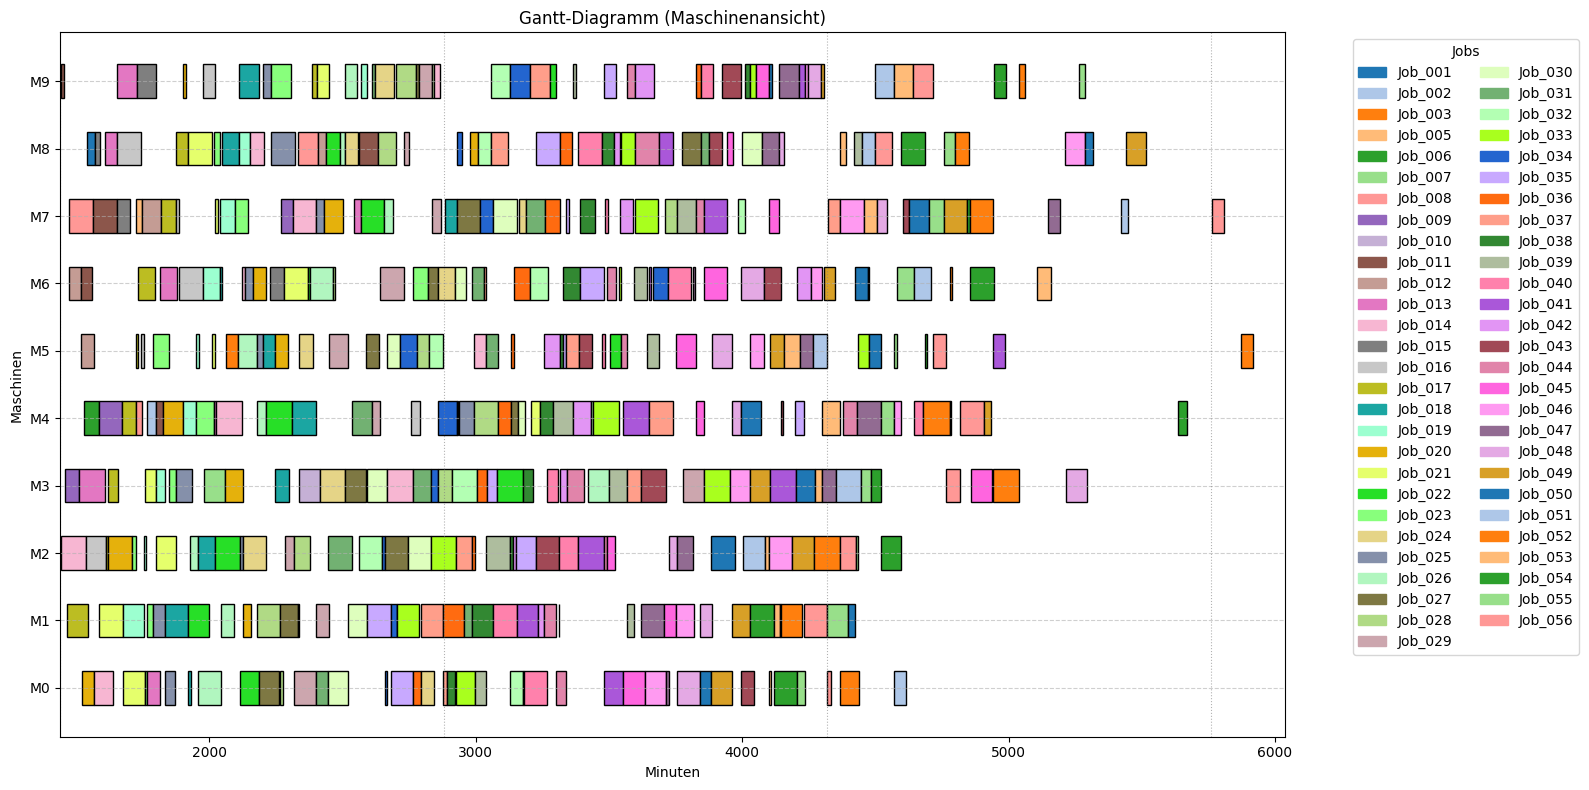

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job


True

In [26]:
show.plot_gantt_machines(df_reschedule)
check.is_machine_conflict_free(df_reschedule)
check.is_operation_sequence_correct(df_reschedule)
check.is_job_timing_correct(df_reschedule)
check.is_start_correct(df_reschedule)

In [27]:
last_ops = df_reschedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
show.count_column_grouped(last_ops, "Lateness", max_val = 180, steps= 60)

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         3
0              51
0 - 60          1
60 - 120        0
120 - 180       0
>180            0
Name: count, dtype: int64

### Combi aus Simulation und Neuplannung

In [28]:
# Relevante Spalten
columns_needed = ["Job", "Operation", "Arrival", "Machine", "Start", "Processing Time", "End"]

# Spalte in df_execution umbenennen
df_execution_important_renamed = df_execution.rename(columns={"Simulated Processing Time": "Processing Time"})

# Auf die gewünschten Spalten beschränken
df_exec_trimmed = df_execution_important_renamed[columns_needed]
df_resched_trimmed = df_reschedule[columns_needed]

# DataFrames zusammenführen
df_combined = pd.concat([df_exec_trimmed, df_resched_trimmed], ignore_index=True)
df_combined

,Job,Operation,Arrival,Machine,Start,Processing Time,End
0,Job_000,0,0,M0,0.00,13.20,13.20
1,Job_000,1,0,M1,29.00,107.22,136.22
2,Job_000,2,0,M2,259.87,7.82,267.69
3,Job_000,3,0,M3,267.69,27.73,295.42
4,Job_000,4,0,M4,321.91,96.68,418.59
...,...,...,...,...,...,...,...
565,Job_051,9,4003,M7,5424.00,25.00,5449.00
566,Job_049,9,3774,M8,5441.00,74.00,5515.00
567,Job_054,9,4015,M4,5638.00,33.00,5671.00
568,Job_056,9,4234,M7,5763.00,45.00,5808.00


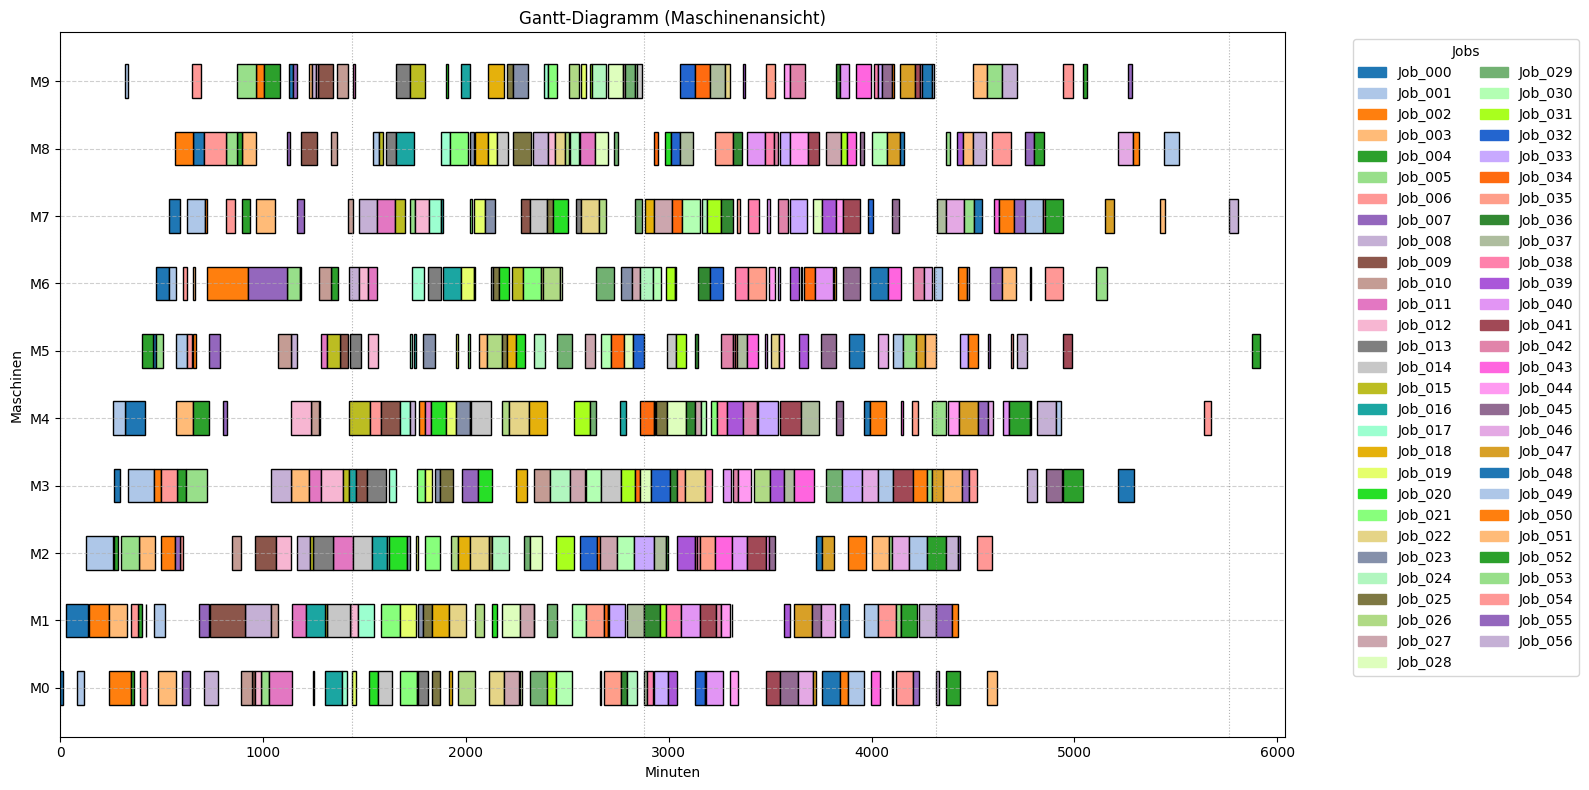

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job


True

In [29]:
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)